In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras

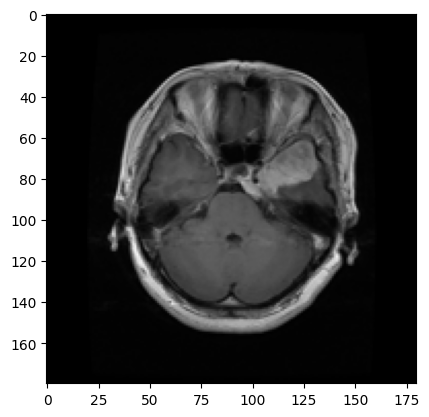

In [44]:
img_path='/kaggle/input/brain-tumor-segmentation/images/1.png'
img_pillow=Image.open(img_path)
img_color=img_pillow.convert('RGB')
img_resize=img_color.resize((180,180))
img_arr=np.array(img_resize)
plt.imshow(img_arr)

In [45]:
img_arr.shape

(180, 180, 3)

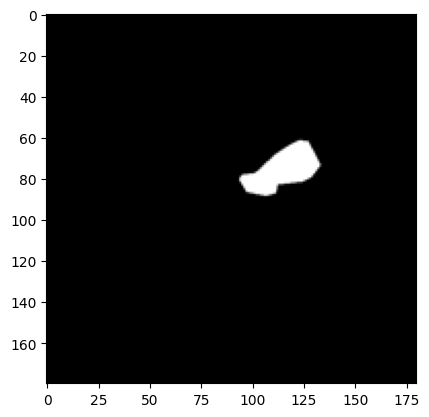

In [46]:
img_mask='/kaggle/input/brain-tumor-segmentation/masks/1.png'
img_pillow=Image.open(img_mask)
img_color=img_pillow.convert('RGB')
img_resize=img_color.resize((180,180))
img_arr=np.array(img_resize)
plt.imshow(img_arr)

In [47]:
img_arr.shape

(180, 180, 3)

In [48]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,LeakyReLU,BatchNormalization
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers import Conv2D, Conv2DTranspose,DepthwiseConv2D
from keras.layers import MaxPooling2D, GlobalMaxPool2D, Concatenate
from keras.layers import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam,SGD
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from tqdm import tqdm

In [49]:
img_folder=os.listdir('/kaggle/input/brain-tumor-segmentation/images/')
mask_folder=os.listdir('/kaggle/input/brain-tumor-segmentation/masks/')
print(len(img_folder))
print(len(mask_folder))

3064
3064


In [51]:
im_width = 256
im_height = 256
ids1 = next(os.walk("/kaggle/input/brain-tumor-segmentation/images/"))[2]
X = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
y = np.zeros((len(ids1), im_height, im_width, 1), dtype=np.float32)
# tqdm is used to display the progress bar
for n, id_ in tqdm(enumerate(ids1), total=len(ids1)):
    # Load images
    img = load_img("/kaggle/input/brain-tumor-segmentation/images/" + id_, color_mode='grayscale')
    x_img = img_to_array(img)
    x_img = resize(x_img, (256,256, 1), mode='constant', preserve_range=True)
    # Load masks
    mask = img_to_array(load_img("/kaggle/input/brain-tumor-segmentation/masks/" + id_, color_mode='grayscale'))
    mask = resize(mask, (256,256, 1), mode='constant', preserve_range=True)
    # Save images
    X[n] = x_img / 255.0
    y[n] = mask / 255.0

100%|██████████| 3064/3064 [01:17<00:00, 39.63it/s]


In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3,shuffle=True)

In [53]:
X_train.shape

(2451, 256, 256, 1)

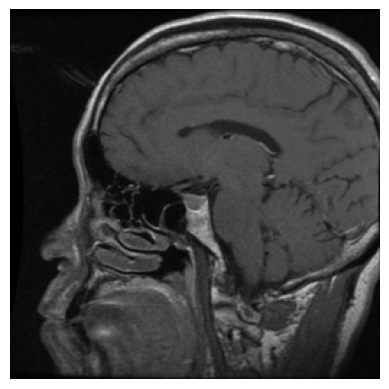

In [54]:
import matplotlib.pyplot as plt

# Assuming x_train has shape (batch_size, height, width, channels)
# Select the index of the image you want to plot
image_index = 0  # Change this to the index of the image you want to plot

# Extract the image
img = X_train[image_index]

# Plot the image
plt.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

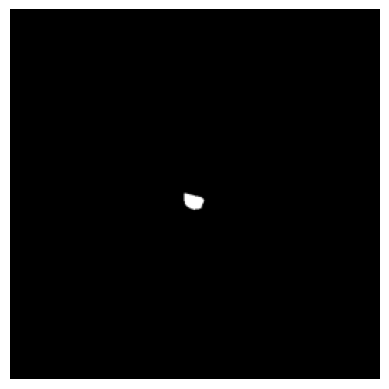

In [55]:
import matplotlib.pyplot as plt

# Assuming x_train has shape (batch_size, height, width, channels)
# Select the index of the image you want to plot
image_index = 0  # Change this to the index of the image you want to plot

# Extract the image
img = y_train[image_index]

# Plot the image
plt.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

In [56]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x
def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

In [57]:
def unet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="UNET")
    return model

model = unet((256,256,1))
model.summary()

Model: "UNET"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        640 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │     36,928 │ activation_18[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │    147,584 │ activation_20[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_23[0][0] 

 Total params: 31,054,145 (118.46 MB)

 Trainable params: 31,042,369 (118.42 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [58]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=4, epochs=3)

Epoch 1/3
613/613 ━━━━━━━━━━━━━━━━━━━━ 286s 340ms/step - accuracy: 0.9740 - loss: 0.1056
Epoch 2/3
613/613 ━━━━━━━━━━━━━━━━━━━━ 151s 246ms/step - accuracy: 0.9826 - loss: 0.0476
Epoch 3/3
613/613 ━━━━━━━━━━━━━━━━━━━━ 151s 246ms/step - accuracy: 0.9842 - loss: 0.0384


In [59]:
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(np.uint8)
y_test = (y_test > 0.5).astype(np.uint8)

20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 632ms/step - accuracy: 0.9777 - loss: 0.0609
Test Accuracy: 0.9776083827018738
20/20 ━━━━━━━━━━━━━━━━━━━━ 14s 662ms/step


In [60]:
model.save('/kaggle/working/BT_Model.hdf5')

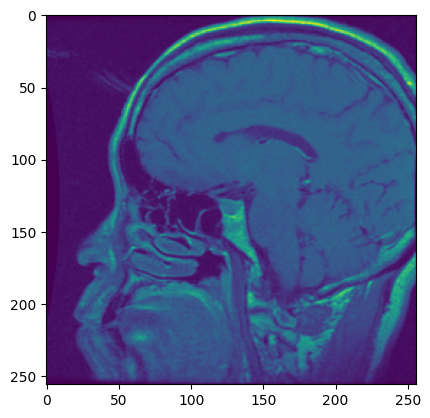

In [61]:
plt.imshow(X_train[0])

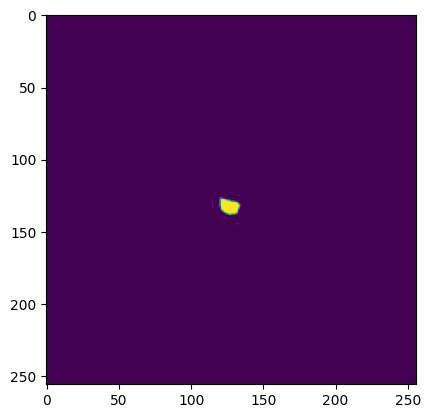

In [62]:
plt.imshow(y_train[0])

Image shape: (1, 256, 256, 1)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


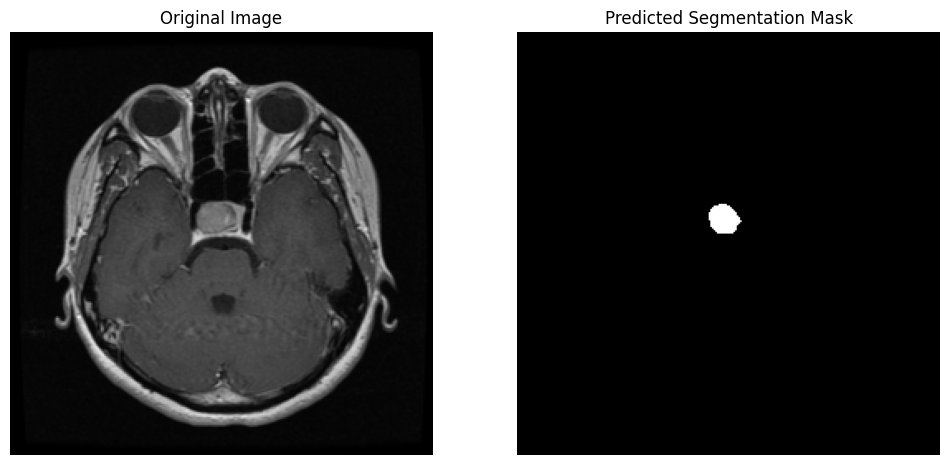

In [67]:
import numpy as np
from keras.preprocessing.image import load_img, img_to_array
from skimage.transform import resize

im_width = 256
im_height = 256

img_path = "/kaggle/input/brain-tumor-segmentation/images/1000.png"

img = load_img(img_path, color_mode='grayscale')
x_img = img_to_array(img)
x_img = resize(x_img, (im_height, im_width, 1), mode='constant', preserve_range=True)
x_img = x_img / 255.0


# Expand dimensions to match model input shape
x_img = np.expand_dims(x_img, axis=0)

# Ensure the data types are float32
x_img = x_img.astype(np.float32)
# Print the shape of the loaded image and mask
print("Image shape:", x_img.shape)


# Perform prediction
predictions = model.predict(x_img)

# Since your model outputs the segmentation mask, you might want to threshold the predictions to obtain a binary mask
threshold = 0.5  # You can adjust this threshold if needed
binary_predictions = (predictions > threshold).astype(np.float32)

# Plot the original image and the predicted segmentation mask
plt.figure(figsize=(12, 6))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(x_img.squeeze(), cmap='gray')
plt.title('Original Image')
plt.axis('off')

# Plot the predicted segmentation mask
plt.subplot(1, 2, 2)
plt.imshow(binary_predictions.squeeze(), cmap='gray')
plt.title('Predicted Segmentation Mask')
plt.axis('off')

plt.show()


In [ ]:
img_path=''

plt.imshow(img.squeeze(), cmap='gray')  # Assuming grayscale images
plt.axis('off')
plt.show()

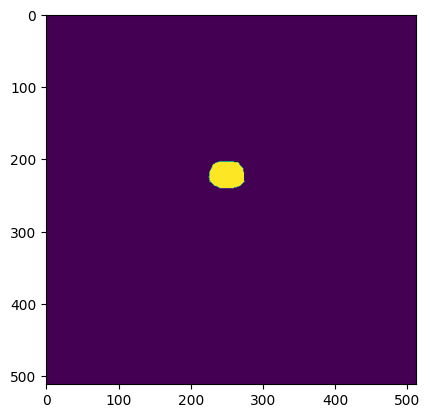

In [68]:
img_pillow=Image.open('/kaggle/input/brain-tumor-segmentation/masks/1000.png')
img_arr=np.array(img_pillow)
plt.imshow(img_arr)